[View in Colaboratory](https://colab.research.google.com/github/rdorff/DeepLearning/blob/master/Lab4.ipynb)

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
import torchvision
from tqdm import tqdm
import pdb
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available()

In [0]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
 
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
 
  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
 
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))
 
 
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
 
  def __len__(self):
    return len(self.dataset_folder)

In [0]:
class CancerDetection(nn.Module):
 
  def __init__(self, dataset):
    super(CancerDetection, self).__init__()
    
    x, y = dataset[0]
    c, h, w = x.size()
  
    self.conv1 = nn.Conv2d(c, 64, kernel_size = 3, stride = 1)    #510
    self.conv2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1)   #508
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1)  #252
    self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1) #250
    
    self.maxpool1 = nn.MaxPool2d(2)                               #254
    
    self.convT1 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride=2)   #500
    
    self.conv5 = nn.Conv2d(128, 64, kernel_size = 3)              #498
    self.conv6 = nn.Conv2d(64, 64, kernel_size = 3)               #496
    self.conv7 = nn.Conv2d(64, 2, kernel_size = 1)                #496
      
 
  def forward(self, input):
    
    # Contraction
    conv1_out = F.relu(self.conv1(input))
    conv2_out = F.relu(self.conv2(conv1_out))
    copy_conv2 = conv2_out[:,:,4:504,4:504]
    maxpool1_out = self.maxpool1(conv2_out)
    
    conv3_out = F.relu(self.conv3(maxpool1_out))
    conv4_out = F.relu(self.conv4(conv3_out))
    
    convT1_out = self.convT1(conv4_out)    #500
    cat1_out = torch.cat((copy_conv2, convT1_out), 1)
    
    conv5_out = F.relu(self.conv5(cat1_out))
    conv6_out = F.relu(self.conv6(conv5_out))
    conv7_out = self.conv7(conv6_out)
    
    return conv7_out
  

  0%|          | 0/1342 [00:00<?, ?it/s]

0.889701 0.2581408321370482


  0%|          | 0/1342 [00:00<?, ?it/s]

0.9093012 0.2184466265872783


  0%|          | 0/1342 [00:00<?, ?it/s]

0.91829294 0.20559718222190035


  0%|          | 0/1342 [00:00<?, ?it/s]

0.92552567 0.19175451058935894


  0%|          | 0/1342 [00:00<?, ?it/s]

0.9286447 0.1836395656105298


  0%|          | 0/1342 [00:00<?, ?it/s]

0.9329552 0.17379317074523265


  0%|          | 0/1342 [00:00<?, ?it/s]

0.9377166 0.16549099082100693


  0%|          | 0/1342 [00:00<?, ?it/s]

0.9407108 0.1591418916200363


  0%|          | 0/1342 [00:00<?, ?it/s]

0.9421274 0.15682242251876705


0.94141346 0.15539416280849686


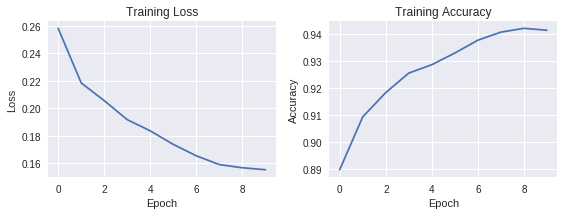

Loss/Accuracy:  tensor(0.2832, device='cuda:0') tensor(0.9002, device='cuda:0')


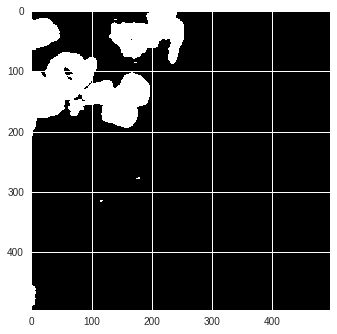

In [12]:
# Loop through data

epoch_accuracy = []
epoch_loss = []


def scope():
  try:
    train_dataset = CancerDataset('/tmp/', download = True, train=True)
    val_dataset = CancerDataset('/tmp/', download = False, train=False)
    train_loader = DataLoader(train_dataset, batch_size=1, pin_memory=True)
    
    gc.collect()
  #  print(torch.cuda.memory_allocated(0) / 1e9)

    model=CancerDetection(train_dataset)
    model = model.cuda()
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(10):

      loop = tqdm(total=len(train_loader), position=0, leave=False)
      train_losses = []
      accuracies = []
      
      # Train Data
      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

        optimizer.zero_grad()
        y_hat = model(x)
        mod_y = y_truth[:,6:502,6:502]

        loss = objective(y_hat, mod_y.long())
        loss.backward()

        train_losses.append(loss.item())

        accuracy = (y_hat.argmax(1).float() == mod_y).float().mean()
        accuracies.append(accuracy)
        
        loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss.item(), accuracy))
        loop.update(1)

        optimizer.step()
        
      epoch_accuracy.append(np.mean(accuracies))
      epoch_loss.append(np.mean(train_losses))
      print(np.mean(accuracies),np.mean(train_losses))

      loop.close() 
  
  except:
    __ITB__()
  
  
  # Plotting
  plt.subplot(2, 2, 1)
  plt.plot(epoch_loss)
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.subplot(2, 2, 2)
  plt.plot(epoch_accuracy)
  plt.title('Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.tight_layout()
  plt.show()
  
  
  # Predict pos_test_000072
  x, y_truth = val_dataset.__getitem__(172)
  x, y_truth = x.cuda(async=True).unsqueeze(0), y_truth.cuda(async=True).unsqueeze(0)
  y_hat = model(x)
  mod_y = y_truth[:,6:502,6:502]

  loss = objective(y_hat, mod_y.long())
  accuracy = (y_hat.argmax(1).float() == mod_y).float().mean()
  
  print("Loss/Accuracy: ", loss.data, accuracy.data)

  cancerous = y_hat.squeeze()[0,:,:] 
  cancerous_copy = cancerous.clone()
  cancerous_copy[cancerous>0] = 0
  cancerous_copy[cancerous<=0] = 1
  
  full_y = torch.stack((cancerous_copy, cancerous_copy, cancerous_copy),0)

  to_pil = torchvision.transforms.ToPILImage()
  pred_img = to_pil(full_y.data.cpu())
  pred_img
  
  npimg = full_y.detach().cpu().numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
scope()